In [1]:
import numpy as np
import pandas as pd

import random

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model
from keras.layers import Dropout, Activation

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [3]:
!nvidia-smi

Fri Dec 23 22:19:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    11W / 200W |    520MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Loading Secondary Data

import glob

path = r'H:/Datasets/CIC-DDoS2019/03-11' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

p = 0.10  # 10% of the lines

#For First Day Data
for filename in all_files:
    #df = pd.read_csv(filename, low_memory=False)
    if filename == "H:/Datasets/CIC-DDoS2019/01-12/TFTP.csv":
        df = pd.read_csv(filename, skiprows=lambda i: i>0 and random.random() > 0.05, low_memory=False)
    elif filename == "H:/Datasets/CIC-DDoS2019/03-11/Portmap.csv" or filename == "H:/Datasets/CIC-DDoS2019/01-12/UDPLag.csv" or filename == "H:/Datasets/CIC-DDoS2019/01-12/UDPLag.csv":        
        df = pd.read_csv(filename, low_memory=False)
    else:        
        df = pd.read_csv(filename, skiprows=lambda i: i>0 and random.random() > p, low_memory=False)
    li.append(df)        
    print("Read Completed for ", filename)
    
#For Second Day Data
path = r'H:/Datasets/CIC-DDoS2019/01-12' # use your path
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)



df = pd.concat(li, axis=0, ignore_index=True)

print("Finished Reading all data...")

Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\LDAP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\MSSQL.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\NetBIOS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\Portmap.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\Syn.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\UDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\UDPLag.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_DNS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_LDAP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_MSSQL.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_NetBIOS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_NTP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_SNMP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_SSDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_UDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019

In [5]:
print(df.shape)

(52098858, 88)


In [6]:
df=df.drop('Unnamed: 0',axis=1)

overfitting_columns = [' Source IP', ' Destination IP', ' Source Port', ' Destination Port', ' Timestamp', 'SimillarHTTP', 'Flow ID', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
df.drop(labels=overfitting_columns, axis='columns', inplace=True)

print("columns: ", len(df.columns))
df.columns

columns:  69


Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' SYN Flag Count', ' RST Flag Count', ' ACK F

In [7]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,17,2,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
1,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
3,17,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
4,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS


In [8]:
df = df.rename(columns={' Label': 'Label'})
df["Label"].value_counts()

TFTP             20082580
DrDoS_SNMP        5159870
DrDoS_DNS         5071011
DrDoS_MSSQL       4522492
DrDoS_NetBIOS     4093279
DrDoS_UDP         3134645
DrDoS_SSDP        2610611
DrDoS_LDAP        2179930
Syn               2072518
DrDoS_NTP         1202642
MSSQL              578950
UDP                385887
UDP-lag            366461
NetBIOS            364763
LDAP               191328
BENIGN              62554
Portmap             18750
WebDDoS               439
UDPLag                148
Name: Label, dtype: int64

In [9]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [10]:
analyze(df)


52098858 rows
**  Protocol:[17:95.02%,6:4.98%,0:0.01%]
**  Flow Duration:1088550 (2%)
**  Total Fwd Packets:716 (0%)
**  Total Backward Packets:335 (0%)
** Total Length of Fwd Packets:5278 (0%)
**  Total Length of Bwd Packets:3395 (0%)
**  Fwd Packet Length Max:2264 (0%)
**  Fwd Packet Length Min:1476 (0%)
**  Fwd Packet Length Mean:8848 (0%)
**  Fwd Packet Length Std:8986 (0%)
** Bwd Packet Length Max:778 (0%)
**  Bwd Packet Length Min:207 (0%)
**  Bwd Packet Length Mean:4958 (0%)
**  Bwd Packet Length Std:5050 (0%)
** Flow Bytes/s:1465899 (2%)
**  Flow Packets/s:1381203 (2%)
**  Flow IAT Mean:1643225 (3%)
**  Flow IAT Std:5368643 (10%)
**  Flow IAT Max:714051 (1%)
**  Flow IAT Min:2768 (0%)
** Fwd IAT Total:1081846 (2%)
**  Fwd IAT Mean:1629967 (3%)
**  Fwd IAT Std:5350808 (10%)
**  Fwd IAT Max:704988 (1%)
**  Fwd IAT Min:817 (0%)
** Bwd IAT Total:69583 (0%)
**  Bwd IAT Mean:70043 (0%)
**  Bwd IAT Std:70596 (0%)
**  Bwd IAT Max:68015 (0%)
**  Bwd IAT Min:130 (0%)
** Fwd PSH Flags:[0

<Figure size 1440x1440 with 0 Axes>

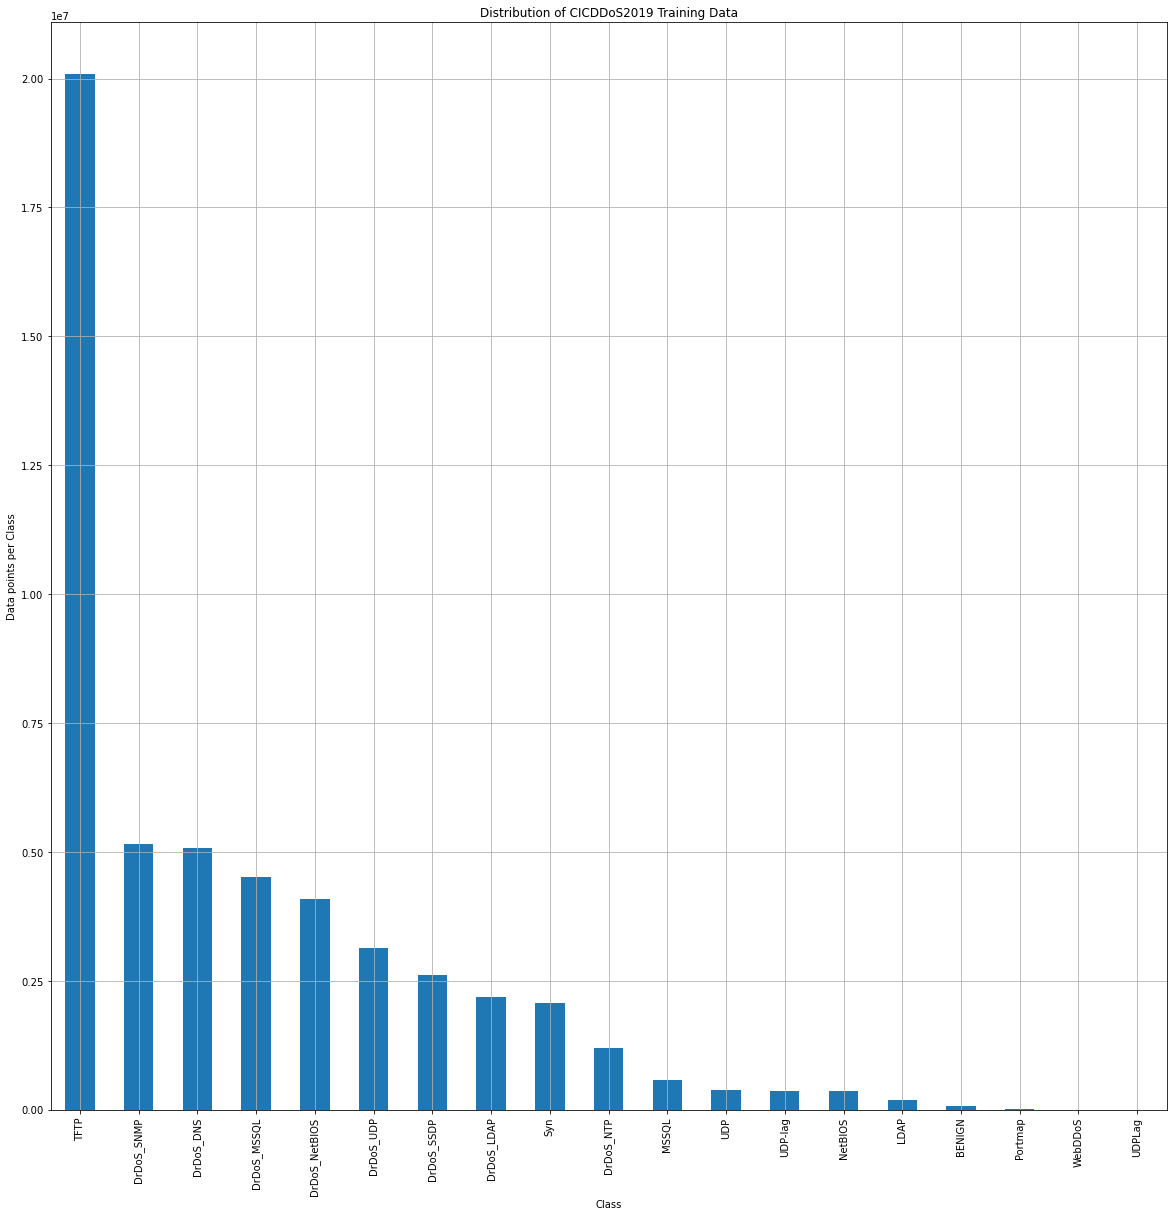

In [11]:
from matplotlib.pyplot import *

plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(20,20))

class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CICDDoS2019 Training Data')
plt.grid()
plt.show()

fig.savefig('CIC-DDoS2019_Data_Distribution.pdf') 

In [12]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class TFTP : 20082580 ( 38.547 %)
Number of data points in class DrDoS_SNMP : 5159870 ( 9.904 %)
Number of data points in class DrDoS_DNS : 5071011 ( 9.733 %)
Number of data points in class DrDoS_MSSQL : 4522492 ( 8.681 %)
Number of data points in class DrDoS_NetBIOS : 4093279 ( 7.857 %)
Number of data points in class DrDoS_UDP : 3134645 ( 6.017 %)
Number of data points in class DrDoS_SSDP : 2610611 ( 5.011 %)
Number of data points in class DrDoS_LDAP : 2179930 ( 4.184 %)
Number of data points in class Syn : 2072518 ( 3.978 %)
Number of data points in class DrDoS_NTP : 1202642 ( 2.308 %)
Number of data points in class MSSQL : 578950 ( 1.111 %)
Number of data points in class UDP : 385887 ( 0.741 %)
Number of data points in class UDP-lag : 366461 ( 0.703 %)
Number of data points in class NetBIOS : 364763 ( 0.7 %)
Number of data points in class LDAP : 191328 ( 0.367 %)
Number of data points in class BENIGN : 62554 ( 0.12 %)
Number of data points in class Portmap :

In [13]:
# Data Cleaning

# Checking for NULL values
print('Null values in dataset are',len(df[df.isnull().any(1)]))
print('='*40)

# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

# stored the data into a pickle file so we can load through
# df.to_pickle('df.pkl')

print("Read {} rows.".format(len(df)))

Null values in dataset are 249036
Read 8576457 rows.


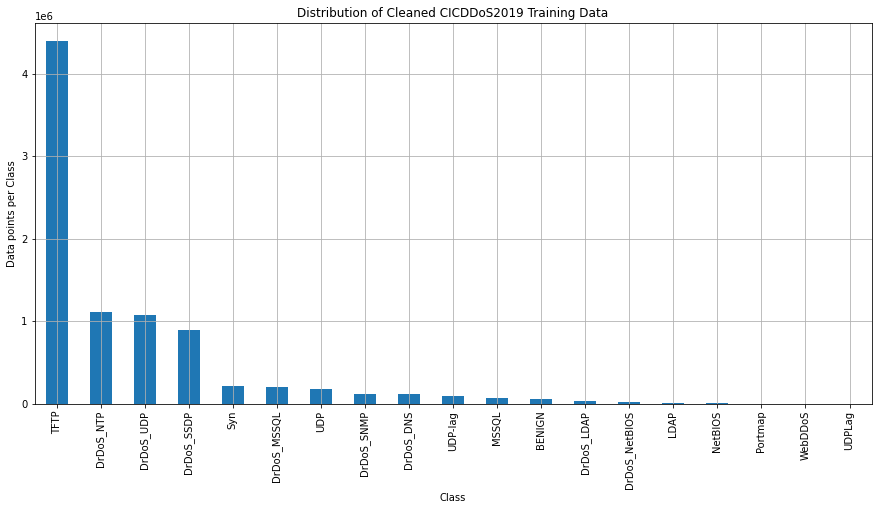

In [14]:
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICDDoS2019 Training Data')
plt.grid()
plt.show()

In [15]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class TFTP : 4396777 ( 51.266 %)
Number of data points in class DrDoS_NTP : 1112904 ( 12.976 %)
Number of data points in class DrDoS_UDP : 1075330 ( 12.538 %)
Number of data points in class DrDoS_SSDP : 891221 ( 10.391 %)
Number of data points in class Syn : 219460 ( 2.559 %)
Number of data points in class DrDoS_MSSQL : 207003 ( 2.414 %)
Number of data points in class UDP : 173408 ( 2.022 %)
Number of data points in class DrDoS_SNMP : 114185 ( 1.331 %)
Number of data points in class DrDoS_DNS : 113259 ( 1.321 %)
Number of data points in class UDP-lag : 89056 ( 1.038 %)
Number of data points in class MSSQL : 70094 ( 0.817 %)
Number of data points in class BENIGN : 55891 ( 0.652 %)
Number of data points in class DrDoS_LDAP : 30099 ( 0.351 %)
Number of data points in class DrDoS_NetBIOS : 19490 ( 0.227 %)
Number of data points in class LDAP : 4888 ( 0.057 %)
Number of data points in class NetBIOS : 2431 ( 0.028 %)
Number of data points in class Portmap : 453 ( 0.0

In [16]:
data = df.iloc[:,1:-1]

In [17]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [18]:
print(df.columns)

Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow Packets/s', ' Flow IAT Mean',
       ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total',
       ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max',
       ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' SYN Flag Count',
       ' RST Flag Count', ' ACK Flag Count', ' UR

In [19]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

14    4396777
4     1112904
8     1075330
7      891221
13     219460
3      207003
15     173408
6      114185
1      113259
16      89056
10      70094
0       55891
2       30099
5       19490
9        4888
11       2431
12        453
18        414
17         94
Name: Label, dtype: int64

In [20]:
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

del df

X = data_np[:, 0:67]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,68:]).toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)


_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (8546566, 67)
Y.shape =  (8546566, 19)
X_train.shape =  (6409924, 67)
y_train.shape =  (6409924, 19)
X_test.shape =  (2136642, 67)
y_test.shape =  (2136642, 19)


In [21]:
del data_np
del data_clean

# DCNNGRU

In [22]:
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape

model=Sequential()
model.add(Convolution1D(64, kernel_size=76, padding="same",activation="relu", input_shape=(67, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(BatchNormalization())

model.add(Dropout(0.1))
model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(24, activation='relu'))    
model.add(Dropout(0.1))

#output Layer
model.add(Dense(19))
model.add(Activation('softmax'))

model.summary()

#optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 64)            4928      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 64)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 33, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 33, 64)            0         
                                                                 
 gru (GRU)                   (None, 33, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 33, 128)           0

In [23]:
early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))  

Epoch 1/30
50078/50078 [==============================] - 369s 7ms/step - loss: 0.0169 - accuracy: 0.9891 - val_loss: 0.0162 - val_accuracy: 0.9909
Epoch 2/30
50078/50078 [==============================] - 361s 7ms/step - loss: 0.0154 - accuracy: 0.9912 - val_loss: 0.0136 - val_accuracy: 0.9919
Epoch 3/30
50078/50078 [==============================] - 362s 7ms/step - loss: 0.0150 - accuracy: 0.9972 - val_loss: 0.0128 - val_accuracy: 0.9952
Epoch 4/30
50078/50078 [==============================] - 365s 7ms/step - loss: 0.0148 - accuracy: 0.9972 - val_loss: 0.0119 - val_accuracy: 0.9953
Epoch 5/30
50078/50078 [==============================] - 364s 7ms/step - loss: 0.0127 - accuracy: 0.9977 - val_loss: 0.0119 - val_accuracy: 0.9955
Epoch 6/30
50078/50078 [==============================] - 363s 7ms/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.0110 - val_accuracy: 0.9955
Epoch 7/30
50078/50078 [==============================] - 362s 7ms/step - loss: 0.0099 - accuracy: 0.9977 - val_

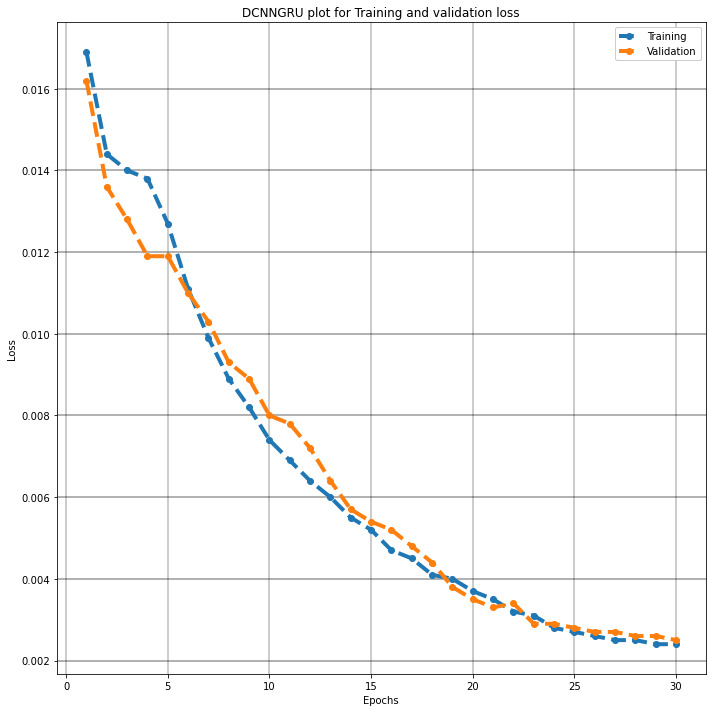

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot of loss vs epoch of train and test dataset
fig, ax = plt.subplots(figsize=(20,15))

ax.set_facecolor("white")

plt.plot(history.history['loss'], 'o--', linewidth=3)
plt.plot(history.history['val_loss'], 'o--', linewidth=3)

plt.grid(axis='x', alpha=.2, color='k', linestyle='-', linewidth=2)
plt.grid(axis='y', alpha=.2, color='k', linestyle='-', linewidth=2)

plt.title("DCNNBiLSTM plot for Training and Testing loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', facecolor='white', framealpha=0.7)
plt.show()

fig.savefig('CIC-DDoS2019_CNN_GRU_DNN_loss.pdf') 

plt.clf()

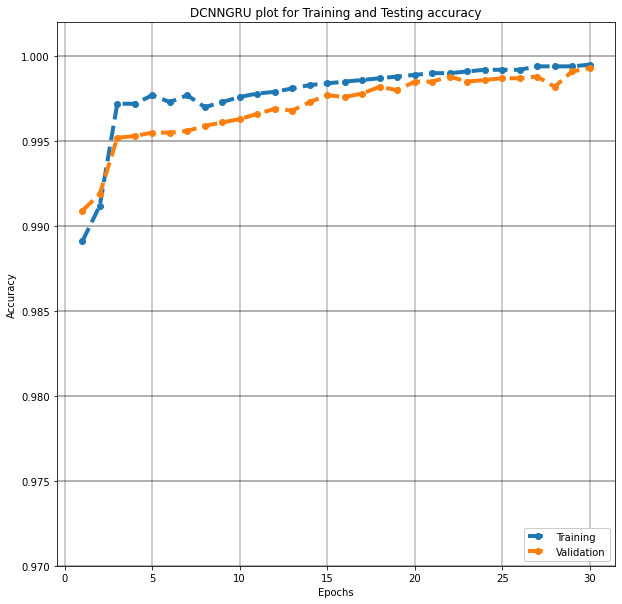

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot of Accuracy vs epoch of train and test dataset
fig, ax = plt.subplots(figsize=(20,15))

ax.set_facecolor("white")

plt.plot(history.history['accuracy'], 'o--', linewidth=3)
plt.plot(history.history['val_accuracy'], 'o--', linewidth=3)

plt.grid(axis='y', alpha=.3, color='k', linestyle='-', linewidth=2)
plt.grid(axis='x', alpha=.2, color='k', linestyle='-', linewidth=2)
plt.ylim(0.90,1.002)

plt.title("DCNNGRU plot for Training and Testing accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right', facecolor='white', framealpha=0.7)

plt.show()

fig.savefig('CIC-DDoS2019_CNN_GRU_DNN_accuracy.pdf') 
plt.clf()

In [26]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

66771/66771 [==============================] - 133s 2ms/step


In [27]:
pred.shape
y_test.shape

(2136642,)

In [28]:
confMat = confusion_matrix(y_test, pred)
confMat

array([[  13561,      84,       2,       5,     100,       8,       3,
              0,      17,       0,       7,       0,       0,      10,
            109,       0,       0,       0,       0],
       [     55,   26271,     514,       0,       2,       0,       0,
              0,       0,       3,       4,       0,       0,       9,
              0,     186,       0,       0,       0],
       [      8,     118,    6712,     350,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       3,
              0,       0,       0,       0,       0],
       [     14,      29,     147,   48096,       1,      83,       0,
              0,       0,       0,       0,       1,       0,       0,
              0,       0,       0,       0,       0],
       [     73,       0,       0,       0,  277071,       5,      29,
              0,       0,       0,       0,       0,       0,       6,
              1,       0,       0,       0,       0],
       [      5,    

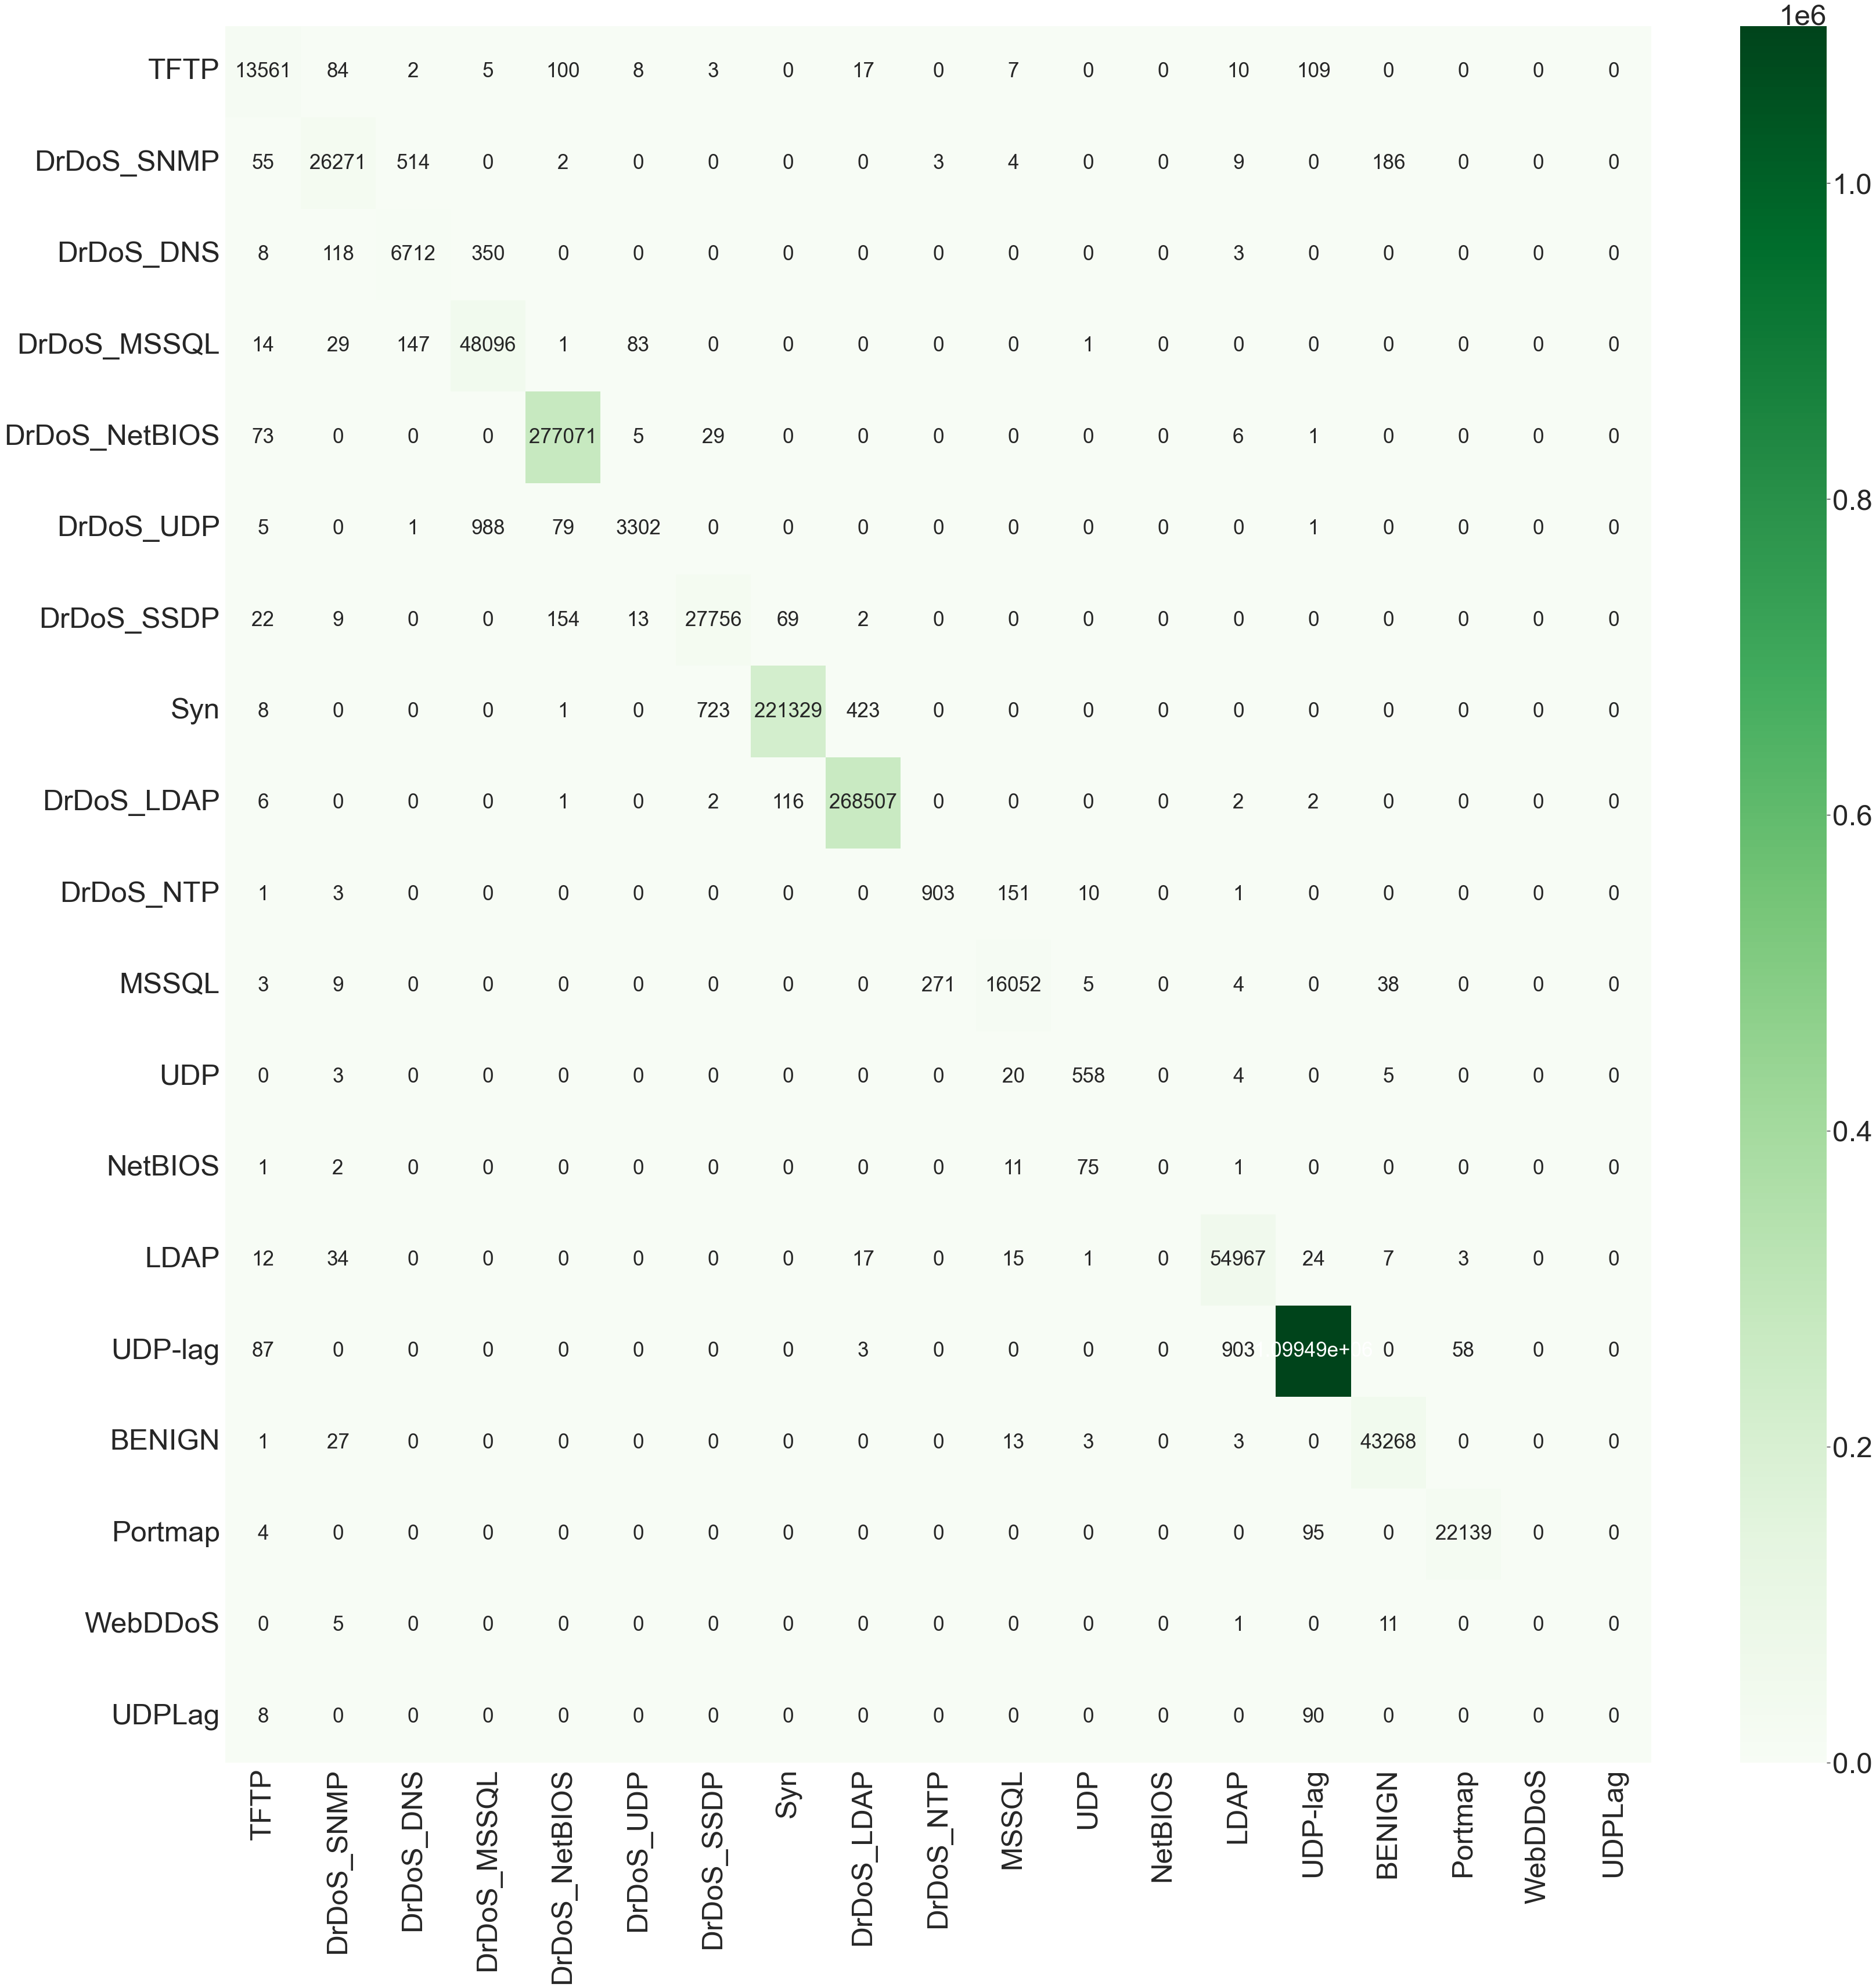

<Figure size 432x288 with 0 Axes>

In [29]:
import seaborn as sn

cm_df = pd.DataFrame(confMat)

labels = ['TFTP','DrDoS_SNMP','DrDoS_DNS','DrDoS_MSSQL','DrDoS_NetBIOS','DrDoS_UDP','DrDoS_SSDP','Syn',
          'DrDoS_LDAP','DrDoS_NTP','MSSQL','UDP','NetBIOS','LDAP','UDP-lag','BENIGN','Portmap','WebDDoS','UDPLag']

fig, ax = plt.subplots(figsize=(55,55))

sn.set(font_scale=3.5)
sn.heatmap(cm_df, annot=True, annot_kws={"size":40}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Greens')
#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()

fig.savefig('CIC-DDoS2019_CNN_GRU_DNN_confusion_metrix.pdf') 
plt.clf()

In [30]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

66771/66771 [==============================] - 134s 2ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:05:28.824160
Validation score: 0.9993248314317513
Evaluation score: [0.002563945342302322, 0.999274822845459]
Recall score: 0.9992348314317513
Precision score: 0.9992313216124882
F1 Measure score: 0.9992371546919848
ROC-AUC score: 0.9425160918016502


In [31]:
file = open("confMat_CICDDoS2019_DCNNGRU.txt", "w+")
# Saving the array in a text file
content = str(confMat)
file.write(content)
file.close()